In [1]:
import numpy as np
import pandas as pd
import geopandas as gpd
from dask.distributed import Client
import s1_rtc_bs_utils
import py3dep
import geopandas as gpd
import rasterio as rio
import pystac
import pystac_client
import stackstac
import math
import shapely
import matplotlib.pyplot as plt
import os
import xarray as xr
from datetime import datetime
import ulmo
from datetime import datetime
import sys

In [2]:
#### CODE FOR DEVELOPMENT-- THIS RELOADS s1_rtc_bs_utils MODULE
#sys.modules.pop('s1_rtc_bs_utils')
#import s1_rtc_bs_utils

In [3]:
# GDAL environment variables for better performance
os.environ['AWS_REGION']='us-west-2'
os.environ['GDAL_DISABLE_READDIR_ON_OPEN']='EMPTY_DIR' 
os.environ['AWS_NO_SIGN_REQUEST']='YES' 
#
xr.set_options(keep_attrs=True)
# Paste /proxy/localhost:8787 for cluster diagnostics
client = Client(local_directory='/tmp', processes=False)
client

<Client: 'inproc://172.25.45.79/2763457/1' processes=1 threads=32, memory=125.71 GiB>

In [4]:
rainier_bbox_gdf = gpd.read_file('shapefiles/mt_rainier.geojson')

# Test get_s1_rtc_stac()

In [5]:
rainier_sar_ds=s1_rtc_bs_utils.get_s1_rtc_stac(rainier_bbox_gdf,start_time='2015-01-01',end_time=datetime.today().strftime('%Y-%m-%d'),orbit_direction='all',polarization='gamma0_vv',collection='mycollection.json')

In [6]:
%%time
# compute frames, drop missing data
rainier_sar_ds = rainier_sar_ds.compute()
rainier_sar_ds = rainier_sar_ds.dropna('time',how='all')

CPU times: user 26.3 s, sys: 3.34 s, total: 29.6 s
Wall time: 18.6 s


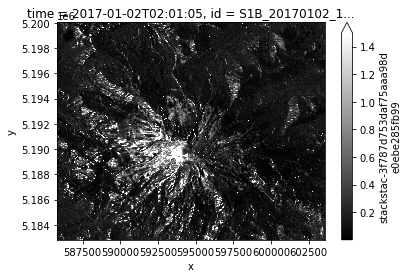

In [7]:
f,ax=plt.subplots()
rainier_sar_ds.isel(time=0).plot(ax=ax,vmax=1.5,cmap='gray')

In [8]:
#np.array(rainier_sar_ds['time'])

In [9]:
#f,ax=plt.subplots(figsize=(30,1))
#f,ax=plt.subplots()
#ax.scatter(np.array(rainier_sar_ds['time']),rainier_sar_ds.coords['sat:orbit_state'])

Text(0.5, 1.0, 'Relative Orbits')

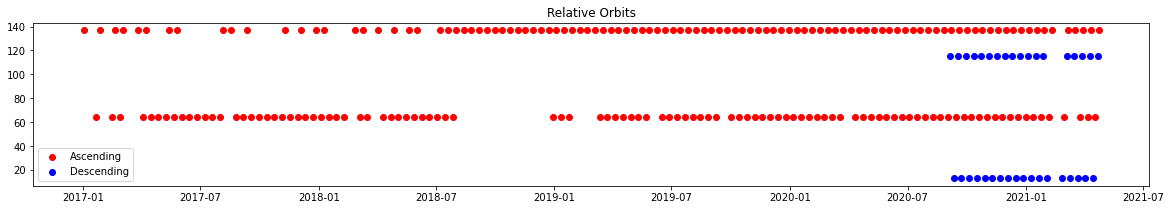

In [10]:
f,ax=plt.subplots(figsize=(20,3))
ax.scatter(np.array(rainier_sar_ds[rainier_sar_ds.coords['sat:orbit_state']=='ascending'].time),rainier_sar_ds[rainier_sar_ds.coords['sat:orbit_state']=='ascending']['sat:relative_orbit'],label='Ascending',c='red')
ax.scatter(np.array(rainier_sar_ds[rainier_sar_ds.coords['sat:orbit_state']=='descending'].time),rainier_sar_ds[rainier_sar_ds.coords['sat:orbit_state']=='descending']['sat:relative_orbit'],label='Descending',c='blue')
ax.legend()
ax.set_title('Relative Orbits')

# Test get_py3dep_dem(), get_py3dep_aspect(), get_py3dep_slope(), get_dah()

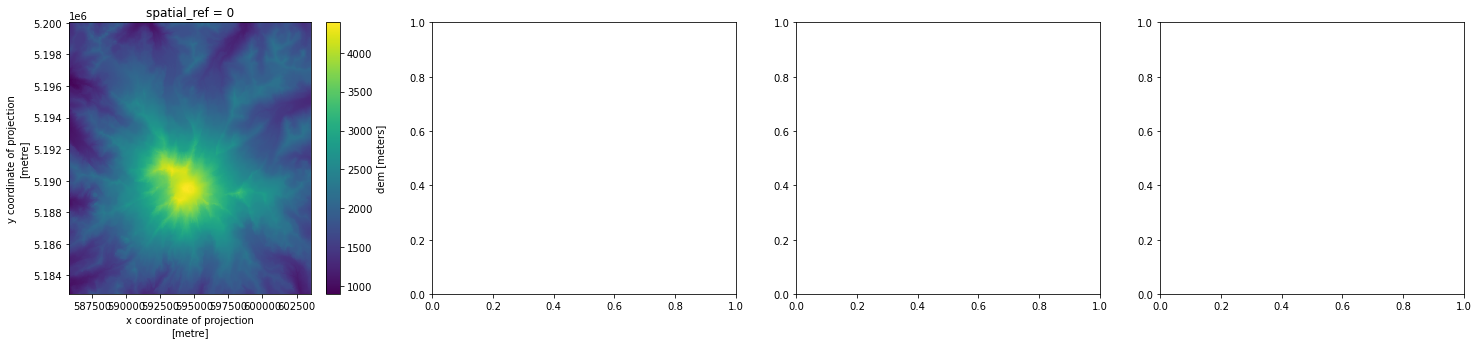

In [12]:
f,ax=plt.subplots(1,4,figsize=(25,5))
s1_rtc_bs_utils.get_py3dep_dem(rainier_sar_ds).plot(ax=ax[0])

In [13]:
s1_rtc_bs_utils.get_py3dep_aspect(rainier_sar_ds).plot(ax=ax[1])

In [14]:
s1_rtc_bs_utils.get_py3dep_slope(rainier_sar_ds).plot(ax=ax[2])

ReadTimeout: HTTPSConnectionPool(host='elevation.nationalmap.gov', port=443): Read timed out. (read timeout=30)

In [15]:
s1_rtc_bs_utils.get_dah(rainier_sar_ds).plot(ax=ax[3])

ReadTimeout: HTTPSConnectionPool(host='elevation.nationalmap.gov', port=443): Read timed out. (read timeout=30)

# Test get_median_ndvi()

In [19]:
dem = s1_rtc_bs_utils.get_py3dep_dem(rainier_sar_ds)
summer_ndvi_ds = s1_rtc_bs_utils.get_median_ndvi(rainier_sar_ds)

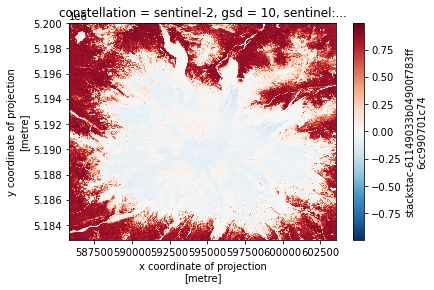

In [20]:
f,ax=plt.subplots()
summer_ndvi_ds.plot(ax=ax)

# Test plot_backscatter_ts_and_ndvi()

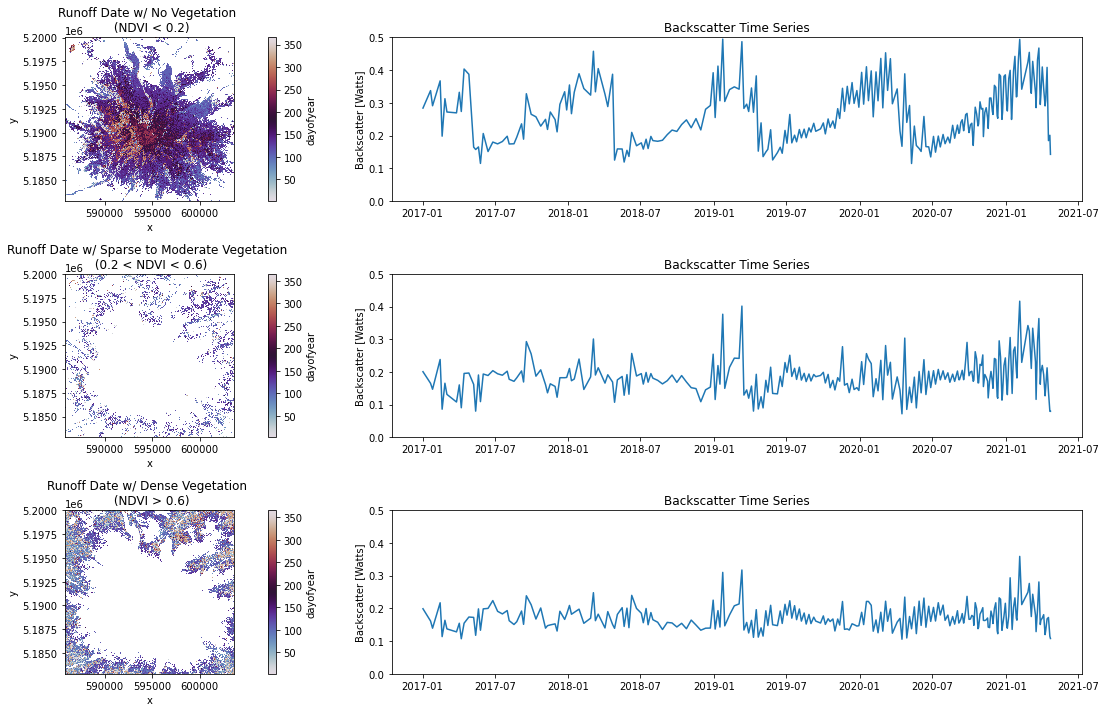

In [21]:
s1_rtc_bs_utils.plot_backscatter_ts_and_ndvi(rainier_sar_ds,summer_ndvi_ds)

# Test get_runoff_onset(), get_ripening_onset()

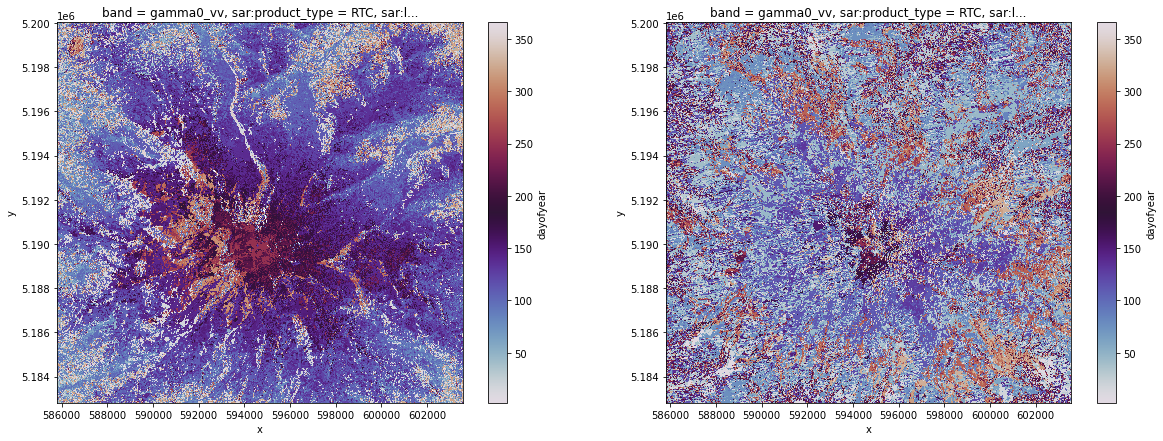

In [22]:
f,ax=plt.subplots(1,2,figsize=(20,7))
s1_rtc_bs_utils.get_runoff_onset(rainier_sar_ds).dt.dayofyear.plot(ax=ax[0],cmap='twilight')
s1_rtc_bs_utils.get_ripening_onset(rainier_sar_ds).dt.dayofyear.plot(ax=ax[1],cmap='twilight')

# Test get_stats()

In [ ]:
stats_full_df = s1_rtc_bs_utils.get_stats(rainier_sar_ds)
stats_ndvi_mask_df = s1_rtc_bs_utils.get_stats(rainier_sar_ds.where(summer_ndvi_ds<0.2,drop=True))

rainier_glaciers = gpd.read_file('shapefiles/rainier_glaciers.geojson').to_crs(rainier_sar_ds.crs)
stats_glacier_mask_df = s1_rtc_bs_utils.get_stats(rainier_sar_ds.rio.clip(rainier_glaciers.geometry,rainier_glaciers.crs,drop=False,invert=False))

In [ ]:
stats_full_df.corr()

In [ ]:
stats_ndvi_mask_df.corr()

In [ ]:
stats_glacier_mask_df.corr()

In [ ]:
f,ax=plt.subplots(1,3,figsize=(30,10))
color1=ax[0].scatter(stats_full_df['dah'],stats_full_df['elevation'],c=stats_full_df['runoff_dates'],s=0.01,cmap='twilight')
color2=ax[1].scatter(stats_ndvi_mask_df['dah'],stats_ndvi_mask_df['elevation'],c=stats_ndvi_mask_df['runoff_dates'],s=0.01,cmap='twilight')
color3=ax[2].scatter(stats_glacier_mask_df['dah'],stats_glacier_mask_df['elevation'],c=stats_glacier_mask_df['runoff_dates'],s=0.01,cmap='twilight')

ax[0].set_title('Runoff Onset Day as a function of DAH and Elevation \n Full Scene')
ax[0].set_xlabel('DAH')
ax[0].set_ylabel('Elevation [m]')
ax[0].set_facecolor('xkcd:grey')

ax[1].set_title('Runoff Onset Day as a function of DAH and Elevation \n with NDVI<0.2 Mask')
ax[1].set_xlabel('DAH')
ax[1].set_ylabel('Elevation [m]')
ax[1].set_facecolor('xkcd:grey')

ax[2].set_title('Runoff Onset Day as a function of DAH and Elevation \n with Glacier Mask')
ax[2].set_xlabel('DAH')
ax[2].set_ylabel('Elevation [m]')
ax[2].set_facecolor('xkcd:grey')

plt.colorbar(color1,ax=ax[0])
plt.colorbar(color2,ax=ax[1])
plt.colorbar(color3,ax=ax[2])

In [ ]:
f,ax = plt.subplots(1,2,figsize=(20,8))
color0 = ax[0].hexbin(stats_glacier_mask_df['dah'],stats_glacier_mask_df['elevation'])
f.colorbar(color0,ax=ax[0])
ax[0].set_title('DAH and Elevation Histogram')
ax[0].set_xlabel('DAH')
ax[0].set_ylabel('Elevation')
ax[0].set_facecolor('xkcd:grey')
color1 = ax[1].hexbin(stats_glacier_mask_df['dah'],stats_glacier_mask_df['elevation'],bins='log')
f.colorbar(color1,ax=ax[1])
ax[1].set_title('DAH and Elevation Histogram (log scale)')
ax[1].set_xlabel('DAH')
ax[1].set_ylabel('Elevation')
ax[1].set_facecolor('xkcd:grey')

In [ ]:
# this plpot is tricky because we need to reduce in some way, but since the values are cylical, most reductions seem invalid
grid_size = 40
f,ax = plt.subplots(1,4,figsize=(40,8))
color0 = ax[0].hexbin(stats_glacier_mask_df['dah'],stats_glacier_mask_df['elevation'],C=stats_glacier_mask_df['runoff_dates'],gridsize=grid_size,cmap='twilight',reduce_C_function=np.mean)
ax[0].set_title('Runoff Onset Day as a function of DAH and Elevation \n Reduced by np.mean')
ax[0].set_xlabel('DAH')
ax[0].set_ylabel('Elevation [m]')
ax[0].set_facecolor('xkcd:grey')
f.colorbar(color0,ax=ax[0])

color1 = ax[1].hexbin(stats_glacier_mask_df['dah'],stats_glacier_mask_df['elevation'],C=stats_glacier_mask_df['runoff_dates'],gridsize=grid_size,cmap='twilight',reduce_C_function=np.median)
ax[1].set_title('Runoff Onset Day as a function of DAH and Elevation \n Reduced by np.median')
ax[1].set_xlabel('DAH')
ax[1].set_ylabel('Elevation [m]')
ax[1].set_facecolor('xkcd:grey')
f.colorbar(color1,ax=ax[1])

color2 = ax[2].hexbin(stats_glacier_mask_df['dah'],stats_glacier_mask_df['elevation'],C=stats_glacier_mask_df['runoff_dates'],gridsize=grid_size,cmap='twilight',reduce_C_function=np.min)
ax[2].set_title('Runoff Onset Day as a function of DAH and Elevation \n Reduced by np.min')
ax[2].set_xlabel('DAH')
ax[2].set_ylabel('Elevation [m]')
ax[2].set_facecolor('xkcd:grey')
f.colorbar(color2,ax=ax[2])

color3 = ax[3].hexbin(stats_glacier_mask_df['dah'],stats_glacier_mask_df['elevation'],C=stats_glacier_mask_df['runoff_dates'],gridsize=grid_size,cmap='twilight',reduce_C_function=np.max)
ax[3].set_title('Runoff Onset Day as a function of DAH and Elevation \n Reduced by np.max')
ax[3].set_xlabel('DAH')
ax[3].set_ylabel('Elevation [m]')
ax[3].set_facecolor('xkcd:grey')
f.colorbar(color3,ax=ax[3])

In [ ]:
f,ax=plt.subplots(2,2,figsize=(15,15))
stats_glacier_mask_ds = stats_glacier_mask_df.to_xarray() 
stats_glacier_mask_ds['runoff_prediction'].plot(cmap='twilight',ax=ax[0,1],vmin=0,vmax=365)
stats_glacier_mask_ds['runoff_dates'].plot(cmap='twilight',ax=ax[0,0],vmin=0,vmax=365)
ax[0,0].set_title('SAR Backscatter Derived DOY Runoff Onset Date')
ax[0,1].set_title('MLS Predicted DOY Runoff Onset Date')
ax[0,0].set_facecolor('xkcd:grey')
ax[0,1].set_facecolor('xkcd:grey')
stats_glacier_mask_ds['ripening_prediction'].plot(cmap='twilight',ax=ax[1,1],vmin=0,vmax=365)
stats_glacier_mask_ds['ripening_dates'].plot(cmap='twilight',ax=ax[1,0],vmin=0,vmax=365)
ax[1,0].set_title('SAR Backscatter Derived DOY Ripening Date')
ax[1,1].set_title('MLS Predicted DOY Ripening Date')
ax[1,0].set_facecolor('xkcd:grey')
ax[1,1].set_facecolor('xkcd:grey')

# Test plot_timeseries_by_elevation_bin(), plot_hyposometry()

In [23]:
resample_freq_s1='2W'
rainier_sar_2w_ds = rainier_sar_ds.where(summer_ndvi_ds.values<0.2).resample(time='2W').mean(dim='time')

Text(0.5, 0.98, 'Mt. Rainier Sentinel-1 SAR Backscatter binned by Elevation \n (Runoff onset happens at the backscatter minimum / darkest pixels) \n each row: backscatter means for a given 100m elevation bin \n top 2 rows are all data, bottom 2 rows are 2 week resampled means')

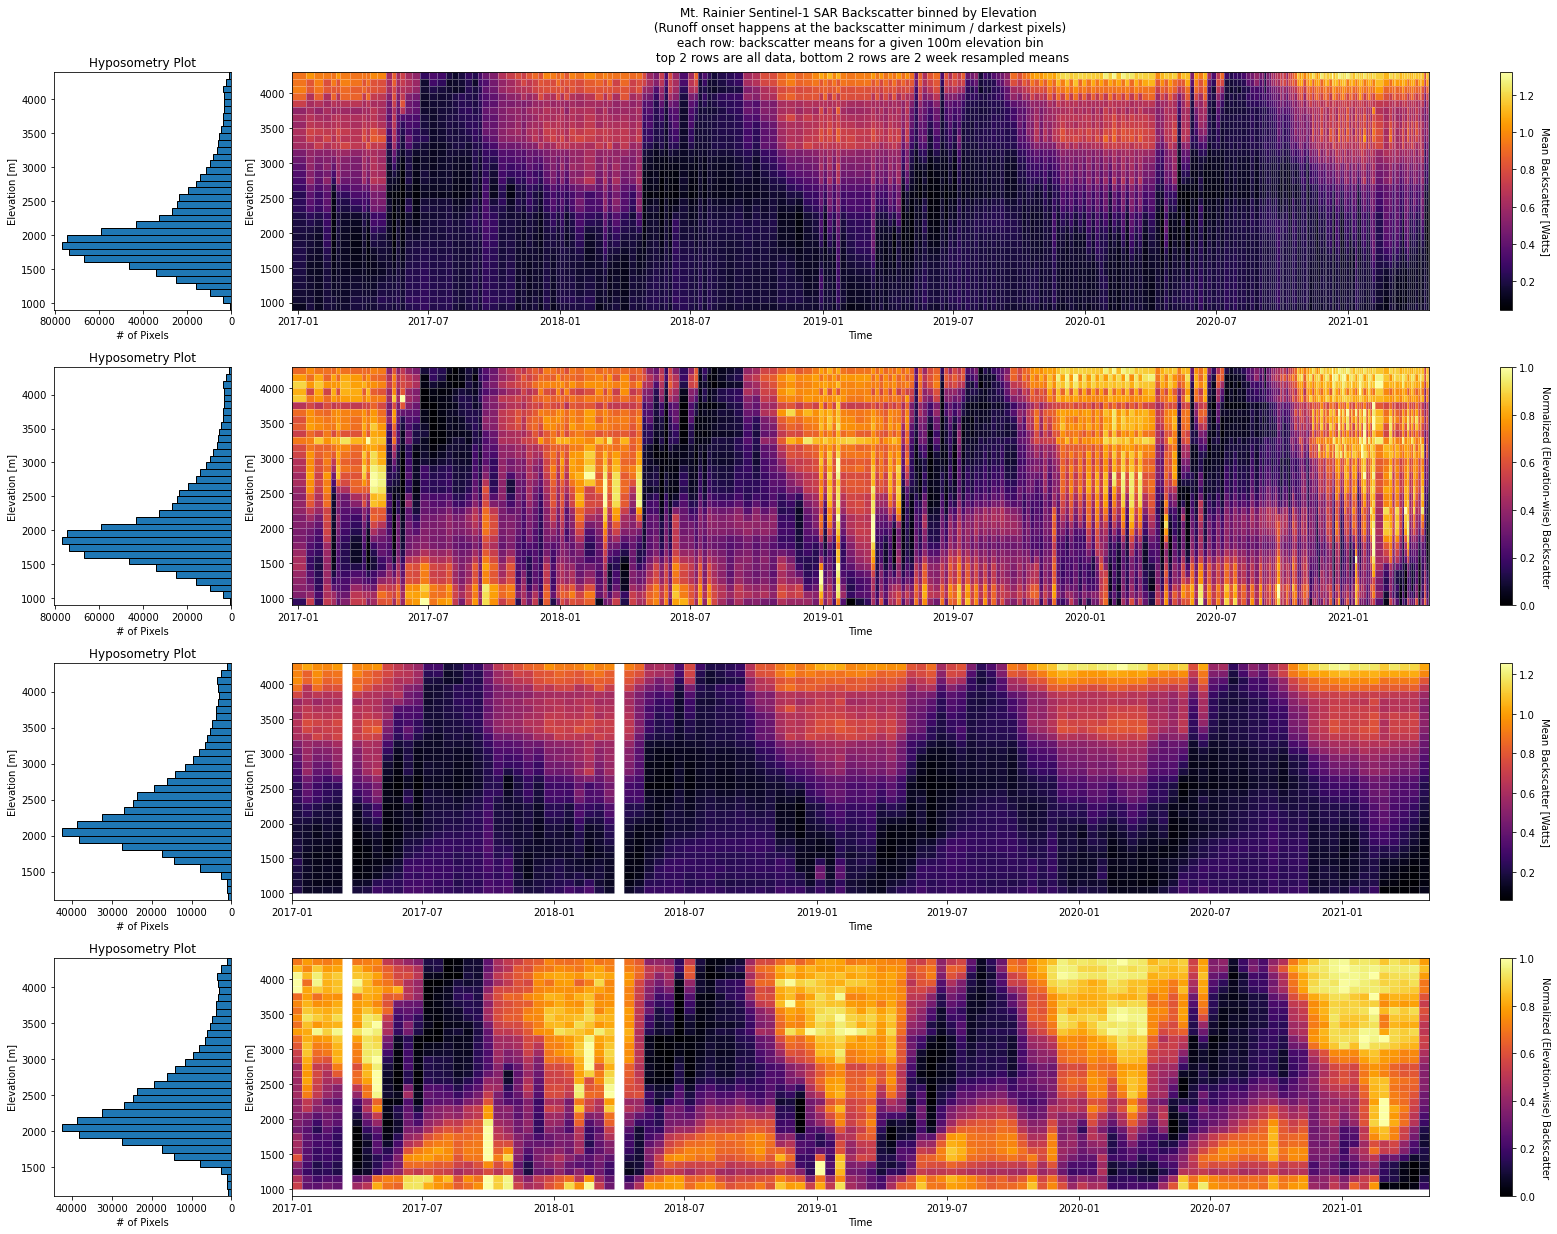

In [24]:
f,ax=plt.subplots(4,2,figsize=(24,18),gridspec_kw={'width_ratios': [1, 8]})
s1_rtc_bs_utils.plot_timeseries_by_elevation_bin(rainier_sar_ds,dem,bin_size=100,ax=ax[0,1],normalize_bins=False)
s1_rtc_bs_utils.plot_timeseries_by_elevation_bin(rainier_sar_ds,dem,bin_size=100,ax=ax[1,1],normalize_bins=True)
s1_rtc_bs_utils.plot_hyposometry(rainier_sar_ds,dem,bin_size=100,ax=ax[0,0])
s1_rtc_bs_utils.plot_hyposometry(rainier_sar_ds,dem,bin_size=100,ax=ax[1,0])
s1_rtc_bs_utils.plot_timeseries_by_elevation_bin(rainier_sar_2w_ds,dem,bin_size=100,ax=ax[2,1],normalize_bins=False)
s1_rtc_bs_utils.plot_timeseries_by_elevation_bin(rainier_sar_2w_ds,dem,bin_size=100,ax=ax[3,1],normalize_bins=True)
s1_rtc_bs_utils.plot_hyposometry(rainier_sar_2w_ds,dem.where(summer_ndvi_ds.values<0.2),bin_size=100,ax=ax[2,0])
s1_rtc_bs_utils.plot_hyposometry(rainier_sar_2w_ds,dem.where(summer_ndvi_ds.values<0.2),bin_size=100,ax=ax[3,0])
ax[0,0].invert_xaxis()
ax[1,0].invert_xaxis()
ax[2,0].invert_xaxis()
ax[3,0].invert_xaxis()
#plt.tight_layout()
f.tight_layout(rect=[0, 0.03, 1, 0.95])
f.suptitle("Mt. Rainier Sentinel-1 SAR Backscatter binned by Elevation \n (Runoff onset happens at the backscatter minimum / darkest pixels) \n each row: backscatter means for a given 100m elevation bin \n top 2 rows are all data, bottom 2 rows are 2 week resampled means")

# Test plot_timeseries_by_dah_bin(), plot_dah_bins()

In [25]:
dah = s1_rtc_bs_utils.get_dah(rainier_sar_ds)

ReadTimeout: HTTPSConnectionPool(host='elevation.nationalmap.gov', port=443): Read timed out. (read timeout=30)

In [ ]:
bin_size = 0.1
f,ax=plt.subplots(2,4,figsize=(24,18),sharex=True,gridspec_kw={'height_ratios': [8, 1]})
s1_rtc_bs_utils.plot_timeseries_by_dah_bin(rainier_sar_ds,dah,bin_size=bin_size,ax=ax[0,0],normalize_bins=False)
s1_rtc_bs_utils.plot_timeseries_by_dah_bin(rainier_sar_ds,dah,bin_size=bin_size,ax=ax[0,1],normalize_bins=True)
s1_rtc_bs_utils.plot_timeseries_by_dah_bin(rainier_sar_2w_ds,dah,bin_size=bin_size,ax=ax[0,2],normalize_bins=False)
s1_rtc_bs_utils.plot_timeseries_by_dah_bin(rainier_sar_2w_ds,dah,bin_size=bin_size,ax=ax[0,3],normalize_bins=True)

s1_rtc_bs_utils.plot_dah_bins(rainier_sar_ds,dah,bin_size=bin_size,ax=ax[1,0])
s1_rtc_bs_utils.plot_dah_bins(rainier_sar_ds,dah,bin_size=bin_size,ax=ax[1,1])
s1_rtc_bs_utils.plot_dah_bins(rainier_sar_2w_ds,dah,bin_size=bin_size,ax=ax[1,2])
s1_rtc_bs_utils.plot_dah_bins(rainier_sar_2w_ds,dah,bin_size=bin_size,ax=ax[1,3])

ax[0,0].set_title('Mean Backscatter')
ax[0,1].set_title('Normalized (DAH-wise) Backscatter')
ax[0,2].set_title('2 Week Resampled Mean Backscatter')
ax[0,3].set_title('2 Week Resampled Normalized (DAH-wise) Backscatter')
#plt.tight_layout(rect=[0, 0, 1, 0.98])
plt.tight_layout()
f.suptitle("Mt. Rainier Sentinel-1 SAR Backscatter binned by DAH \n (Runoff onset happens at the backscatter minimum / darkest pixels) \n each column: backscatter for a given 0.25 DAH bin \n (DAH = 1 has greatest insolation, DAH = -1 has the least insolation)")

# Test find_closest_snotel()

In [ ]:
s1_rtc_bs_utils.find_closest_snotel(rainier_sar_ds)

# Test plot_closest_snotel()

In [ ]:
f, ax = plt.subplots(figsize=(15,15))
s1_rtc_bs_utils.plot_closest_snotel(rainier_sar_ds,distance_cutoff=40,ax=ax)

# Test get_snotel()

In [ ]:
sitecode = 'SNOTEL:679_WA_SNTL'
#variablecode = 'SNOTEL:TAVG_D'
#variablecode = 'SNOTEL:PRCPSA_D'
#variablecode = 'SNOTEL:WTEQ_D'
values_df = s1_rtc_bs_utils.get_snotel(sitecode, variable_code='SNOTEL:SNWD_D',start_date='1900-01-01', end_date=datetime.today().strftime('%Y-%m-%d'))
values_df['value'] = 2.54*values_df['value'] #inches to cm
values_df

# Test get_closest_snotel_data()

In [ ]:
snotel_data = s1_rtc_bs_utils.get_closest_snotel_data(rainier_sar_ds,variable_code='SNOTEL:SNWD_D',distance_cutoff=30,start_date='1900-01-01', end_date=datetime.today().strftime('%Y-%m-%d'))

In [ ]:
f, ax = plt.subplots(figsize=(30,10))
snotel_data.plot(ax=ax)
ax.set_xlabel('Time')
ax.set_ylabel('Snow Depth [m]')
ax.set_title('Snow Depth for SNOTEL Stations Close in Proximety to Dataset')

# Test get_s2_ndsi()

In [ ]:
snow=s1_rtc_bs_utils.get_s2_ndsi(rainier_sar_ds.where(summer_ndvi_ds.values<0.2))

In [ ]:
snow.plot.imshow(col="time", col_wrap = 10, robust=True);

In [ ]:
f,ax = plt.subplots(figsize=(20,8))
ax.plot(snow.time,snow.mean(dim=['x','y']))

In [ ]:
f,ax=plt.subplots(figsize=(20,8))
s1_rtc_bs_utils.plot_timeseries_by_elevation_bin(snow,dem,ax=ax,normalize_bins=True)
ax.set_title('NDSI Values binned by elevation')

# Test get_s2_rgb()

In [ ]:
snow_rgb=s1_rtc_bs_utils.get_s2_rgb(rainier_sar_ds)

In [ ]:
snow_rgb.where(summer_ndvi_ds.rio.reproject_match(snow_rgb).values<0.2).plot.imshow(col="time", col_wrap = 10, rgb='band', robust=True,aspect=1);

# Test plot_bs_ndsi_swe_precip()

In [ ]:
rainier_sar_2020_ds=s1_rtc_bs_utils.get_s1_rtc_stac(rainier_bbox_gdf,start_time='2020-01-01',end_time='2021-01-01',orbit_direction='all',polarization='gamma0_vv',collection='mycollection.json')
rainier_sar_2020_ds = rainier_sar_2020_ds.compute()
rainier_sar_2020_ds = rainier_sar_2020_ds.dropna('time',how='all')
rainier_sar_2020_glaciers_ds = rainier_sar_2020_ds.rio.clip(rainier_glaciers.geometry,rainier_glaciers.crs,drop=False,invert=False)

In [ ]:
def plot_bs_ndsi_swe_precip(ts_ds,ax=None,start_date='1900-01-01', end_date=datetime.today().strftime('%Y-%m-%d')):
    if ax is None:
        ax = plt.gca()
    f = plt.gcf()    
    
    plt.style.use('seaborn-dark')

    snwd_ax = ax.twinx()
    precip_ax = ax.twinx()
    ndsi_ax = ax.twinx()
    
    #host.set_xlim(0, 2)
    #host.set_ylim(0, 2)
    #par1.set_ylim(0, 4)
    #par2.set_ylim(1, 65)
    #snwd_ax.set_ylim(bottom=0)
    snwd_ax.set_ylim([0,480])

    
    ax.set_xlabel("Time")
    ax.set_ylabel("Backscatter [Watts]")
    snwd_ax.set_ylabel("Snow Depth / SWE [cm]")
    precip_ax.set_ylabel("Precipitation [cm]")
    ndsi_ax.set_ylabel("NDSI")

    bs_plot1, = ax.plot(ts_ds[ts_ds.coords['sat:orbit_state']=='ascending'].time,ts_ds[ts_ds.coords['sat:orbit_state']=='ascending'].mean(dim=['x','y']),color='red',label='Backscatter (Ascending)')
    bs_plot2, = ax.plot(ts_ds[ts_ds.coords['sat:orbit_state']=='descending'].time,ts_ds[ts_ds.coords['sat:orbit_state']=='descending'].mean(dim=['x','y']),color='orange',label='Backscatter (Descending)')

    snow = s1_rtc_bs_utils.get_s2_ndsi(ts_ds)
    ndsi_plot, = ndsi_ax.plot(snow.time,snow.mean(dim=['x','y']),color='green',label='NDSI')
    snotel_snwd = s1_rtc_bs_utils.get_closest_snotel_data(rainier_sar_ds,variable_code='SNOTEL:SNWD_D',distance_cutoff=1.5,closest=True,start_date='1900-01-01', end_date=datetime.today().strftime('%Y-%m-%d'))
    snwd_plot = snwd_ax.scatter(snotel_snwd.index,2.54*snotel_snwd.iloc[:,0],color='blueviolet',alpha=0.7,label='Snow Depth')
    
    snotel_swe = s1_rtc_bs_utils.get_closest_snotel_data(rainier_sar_ds,variable_code='SNOTEL:WTEQ_D',distance_cutoff=1.5,closest=True,start_date='1900-01-01', end_date=datetime.today().strftime('%Y-%m-%d'))
    swe_plot = snwd_ax.scatter(snotel_swe.index,2.54*snotel_swe.iloc[:,0],color='darkturquoise',alpha=0.7,label='SWE')
    
    #print(snotel_snwd)
    #ax.scatter(x=snotel_snwd.index,y=snotel_snwd['value'],label='Snow Depth')
    snotel_precip = s1_rtc_bs_utils.get_closest_snotel_data(rainier_sar_ds,variable_code='SNOTEL:PRCPSA_D',distance_cutoff=1.5,closest=True,start_date='1900-01-01', end_date=datetime.today().strftime('%Y-%m-%d'))
    precip_plot = precip_ax.bar(snotel_precip.index,2.54*snotel_precip.iloc[:,0],color='blue',alpha=0.4,label='Precipitation')
    lns = [bs_plot1,bs_plot2,ndsi_plot,snwd_plot,swe_plot,precip_plot]
    ax.legend(handles=lns,loc='best')
    #time_slice = slice('2015-01-01','2022-01-01')
    #ax.set_xlim([time_slice.start,time_slice.stop])
    
    precip_ax.spines['right'].set_position(('outward', 60))
    ndsi_ax.spines['left'].set_position(('outward', 60))
    #ndsi_ax.yaxis.label.set_position(('outward', 60))
    
    ndsi_ax.spines["left"].set_visible(True)
    ndsi_ax.yaxis.set_label_position('left') 
    ndsi_ax.yaxis.set_ticks_position('left')
    
    ax.yaxis.label.set_color(bs_plot1.get_color())
    ndsi_ax.yaxis.label.set_color(ndsi_plot.get_color())
    snwd_ax.yaxis.label.set_color('blueviolet')
    precip_ax.yaxis.label.set_color('blue')
    
    ax.set_xlim([datetime.strptime(start_date,'%Y-%m-%d'),datetime.strptime(end_date,'%Y-%m-%d')])   
    
    ax.set_title('S1 Backscatter, S2 NDSI, SNOTEL Snow Depth, SWE, and Precipitation')
    plt.tight_layout()
    
    ff,axax=plt.subplots()
    ts_ds.isel(time=0).plot(ax=axax,vmax=1.0,cmap='gray',add_colorbar=False)
    ctx.add_basemap(ax=axax, crs=ts_ds.crs, source=ctx.providers.Stamen.Terrain)

In [ ]:
f,ax=plt.subplots(figsize=(20,8))
#plt.style.use('seaborn')
#plot_bs_ndsi_swe_precip(rainier_sar_ds,ax=ax,start_date='2016-01-01')
plot_bs_ndsi_swe_precip(rainier_sar_2020_glaciers_ds,ax=ax,start_date='2020-01-01',end_date='2021-01-01')

In [ ]:
#rainier_sar_ds['sat:relative_orbit']


In [ ]:
# run on smaller area too. maybe left pane have area of interest in rgb

# aggregate_by_doy() #averages and such

# predict_runoff_with_ndsi()

In [ ]:
# TODO .aggregate_by_time() .plot_gif() .plot_runoff() .plot_ripening() .plot_bs_snotel_swe_precip_ndsi() 